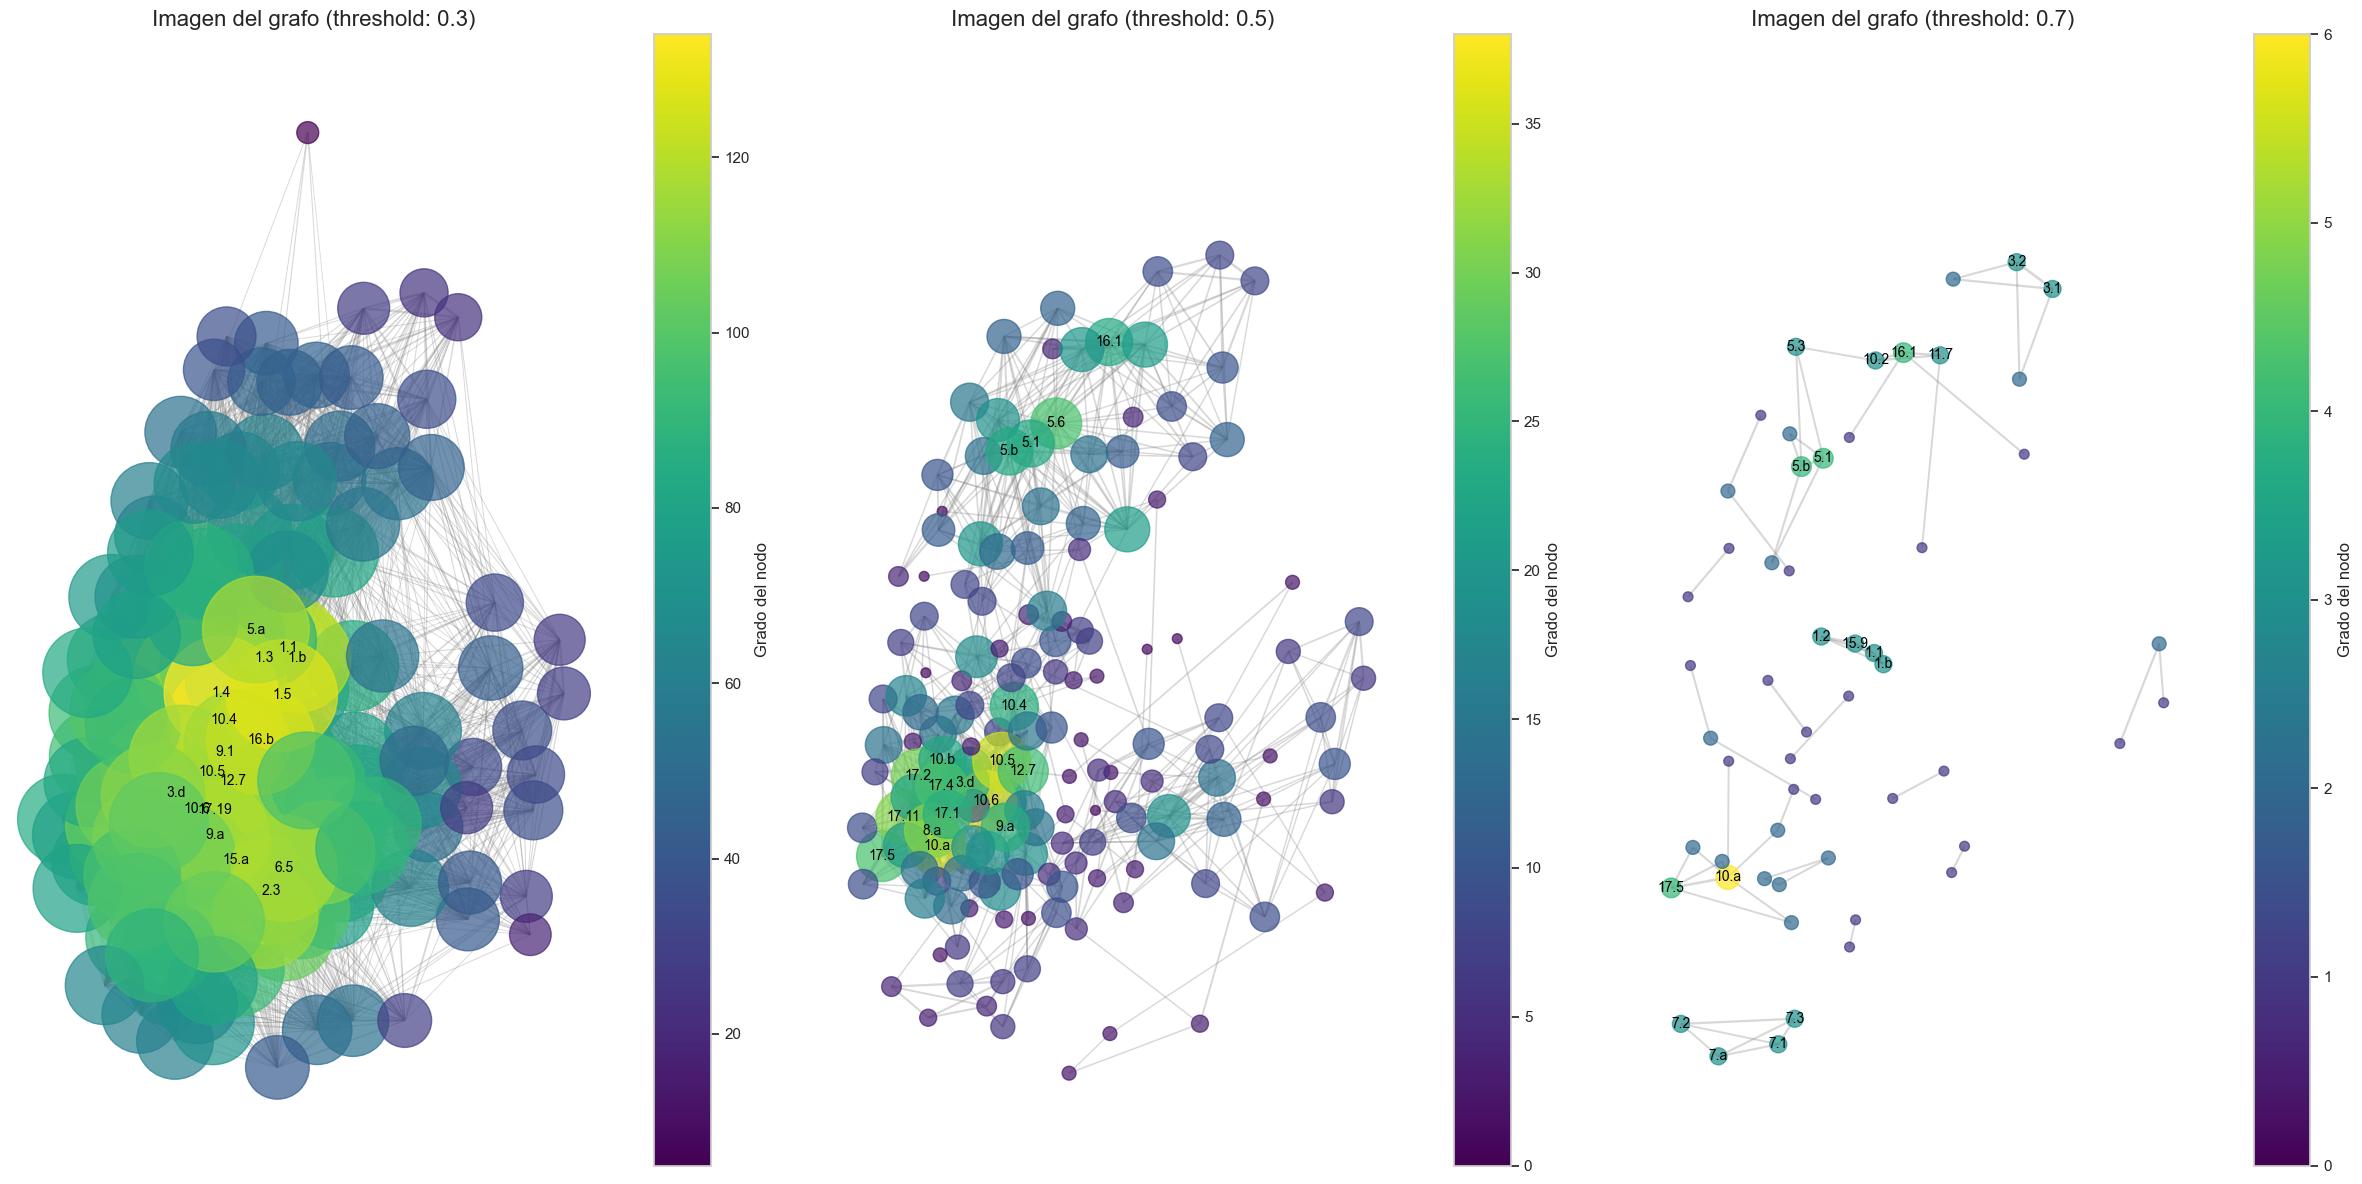

In [2]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns  # Para mejorar la estética de los gráficos

# Configuración de estilo de Seaborn para mejores gráficos
sns.set(style="whitegrid")

# ==========================================
# Paso 1: Cargar la matriz de similitud desde el archivo CSV
# ==========================================
df = pd.read_csv('data/nuevo_dataframe.csv', index_col=0)

# ==========================================
# Paso 2: Definir los umbrales con claves numéricas
# ==========================================
thresholds = {
    1: 0.3,
    2: 0.5,
    3: 0.7
}

# Nombre del grafo
nombre_grafo = "Imagen del grafo"

# ==========================================
# Paso 3: Crear los grafos para cada umbral
# ==========================================
grafos = {}
for clave, umbral in thresholds.items():
    # Crear un grafo vacío
    G = nx.Graph()
    
    # Añadir nodos
    G.add_nodes_from(df.index)
    
    # Añadir aristas basadas en el umbral
    # Iterar sobre la matriz de similitud
    for i in df.index:
        for j in df.columns:
            if i != j:
                similitud = df.at[i, j]
                if similitud >= umbral:
                    G.add_edge(i, j, weight=similitud)
    
    grafos[clave] = G

# ==========================================
# Paso 4: Definir una posición para los nodos
# ==========================================
# Usaremos un layout que distribuye mejor los nodos en grafos grandes
pos = nx.spring_layout(grafos[1], seed=42, k=0.1, iterations=50)

# ==========================================
# Paso 5: Configurar la figura para contener los subgráficos de los grafos
# ==========================================
fig_grafos, axes_grafos = plt.subplots(1, 3, figsize=(24, 12))

# ==========================================
# Paso 6: Dibujar cada grafo en su propio subgráfico
# ==========================================
for ax, (clave, G) in zip(axes_grafos, grafos.items()):
    # Calcular el grado de cada nodo
    grados = dict(G.degree())
    
    # Normalizar los grados para el tamaño de los nodos
    node_sizes = [v * 50 for v in grados.values()]
    
    # Dibujar nodos
    nodes = nx.draw_networkx_nodes(
        G, pos, ax=ax,
        node_size=node_sizes,
        node_color=list(grados.values()),
        cmap=plt.cm.viridis,
        alpha=0.7
    )
    
    # Dibujar aristas
    edges = G.edges(data=True)
    # Normalizar los pesos para el grosor de las aristas
    edge_widths = [edata['weight'] * 2 for _, _, edata in edges]
    nx.draw_networkx_edges(
        G, pos, ax=ax,
        edgelist=edges,
        width=edge_widths,
        alpha=0.3,
        edge_color='gray'
    )
    
    # Añadir una barra de colores para los nodos
    sm = plt.cm.ScalarMappable(cmap=plt.cm.viridis, 
                               norm=plt.Normalize(vmin=min(grados.values()), vmax=max(grados.values())))
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=ax)
    cbar.set_label('Grado del nodo')
    
    # Mostrar etiquetas solo para nodos con grado alto (percentil 90)
    umbral_grado = pd.Series(grados).quantile(0.9)
    etiquetas = {n: n for n, d in grados.items() if d >= umbral_grado}
    nx.draw_networkx_labels(
        G, pos, ax=ax,
        labels=etiquetas,
        font_size=10,
        font_color='black'
    )
    
    # Título del subgráfico con el formato deseado
    ax.set_title(f'{nombre_grafo} (threshold: {thresholds[clave]})', fontsize=16)
    
    # Eliminar los ejes
    ax.set_axis_off()

# Ajustar el layout y mostrar la figura de los grafos
plt.tight_layout()
plt.show()


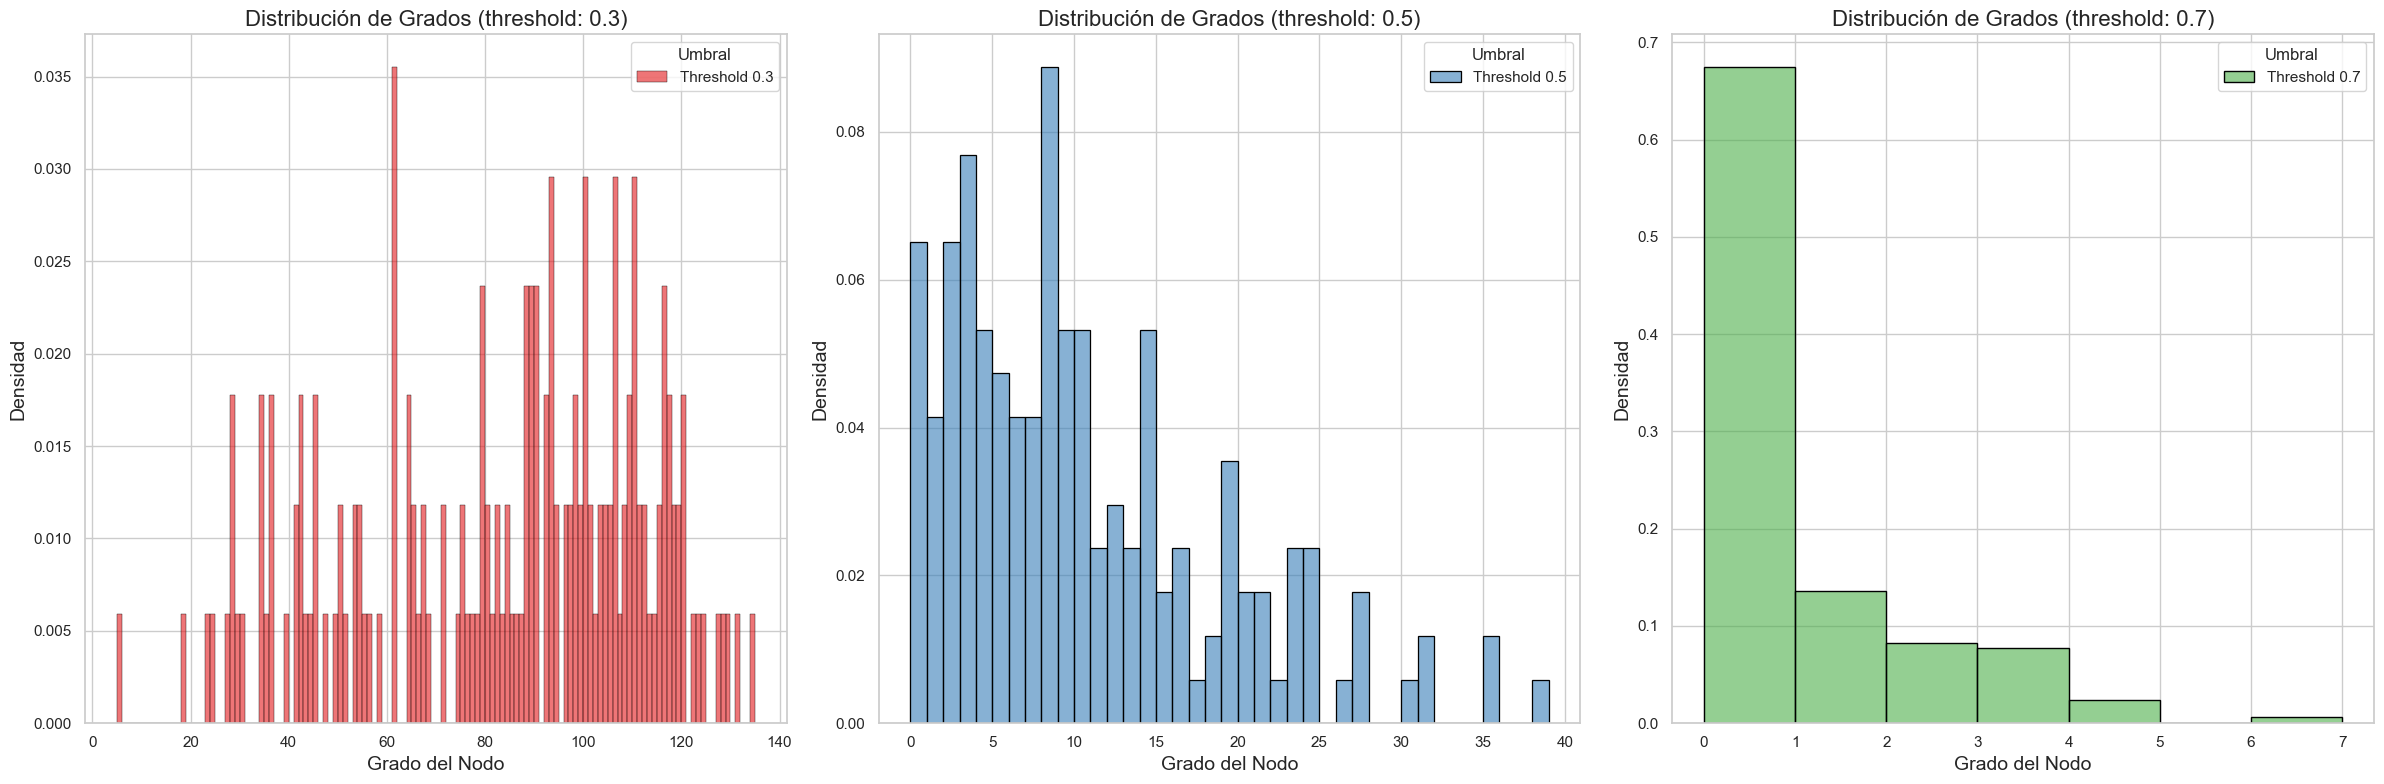

In [3]:
# ==========================================
# Paso 7: Crear y Visualizar la Distribución de Grados en Subgráficos Separados
# ==========================================
# Crear una nueva figura para la distribución de grados con 3 subgráficos
fig_grados, axes_grados = plt.subplots(1, 3, figsize=(24, 8))

# Definir una paleta de colores para los diferentes umbrales
palette = sns.color_palette("Set1", len(thresholds))

# Iterar sobre cada grafo para calcular y plotear la distribución de grados
for idx, (clave, G) in enumerate(grafos.items()):
    grados = [degree for node, degree in G.degree()]
    
    # Plotear el histograma de grados en su propio subgráfico
    sns.histplot(grados, bins=range(min(grados), max(grados)+2), 
                 kde=False, stat="density", label=f'Threshold {thresholds[clave]}', 
                 color=palette[idx], alpha=0.6, edgecolor='black', ax=axes_grados[idx])
    
    # Añadir título y etiquetas a cada subgráfico
    axes_grados[idx].set_title(f'Distribución de Grados (threshold: {thresholds[clave]})', fontsize=16)
    axes_grados[idx].set_xlabel('Grado del Nodo', fontsize=14)
    axes_grados[idx].set_ylabel('Densidad', fontsize=14)
    
    # Añadir leyenda a cada subgráfico
    axes_grados[idx].legend(title='Umbral')

# Ajustar el layout y mostrar la figura de la distribución de grados
plt.tight_layout()
plt.show()

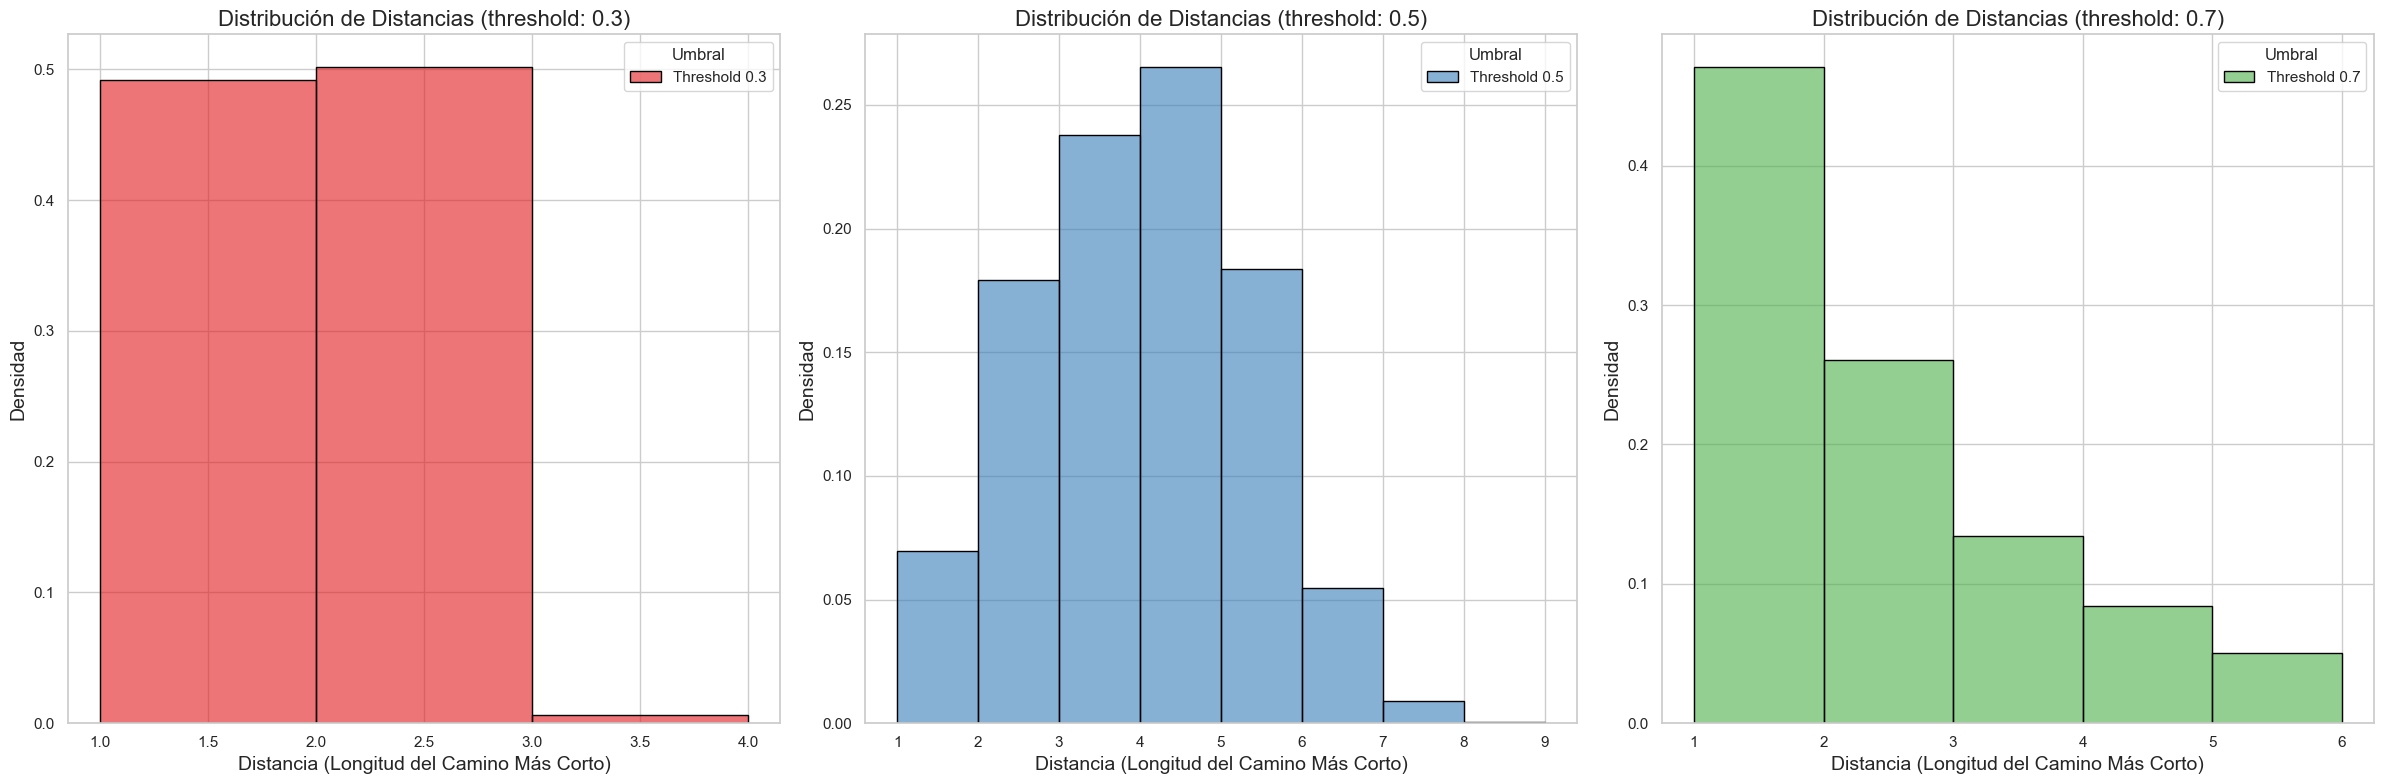

In [4]:
# ==========================================
# Paso 8: Crear y Visualizar la Distribución de Distancias en Subgráficos Separados
# ==========================================
# Crear una nueva figura para la distribución de distancias con 3 subgráficos
fig_distancias, axes_distancias = plt.subplots(1, 3, figsize=(24, 8))

# Iterar sobre cada grafo para calcular y plotear la distribución de distancias
for idx, (clave, G) in enumerate(grafos.items()):
    # Verificar si el grafo está conectado
    if nx.is_connected(G):
        # Si está conectado, calcular todas las distancias
        distancias = []
        for source, lengths in nx.all_pairs_shortest_path_length(G):
            distancias.extend(lengths.values())
    else:
        # Si no está conectado, calcular distancias solo en componentes conectados
        distancias = []
        for component in nx.connected_components(G):
            subgraph = G.subgraph(component)
            for source, lengths in nx.all_pairs_shortest_path_length(subgraph):
                distancias.extend(lengths.values())
    
    # Remover distancias de 0 (distancia de un nodo a sí mismo)
    distancias = [d for d in distancias if d > 0]
    
    # Convertir a una serie de pandas para facilitar el manejo
    distancias_series = pd.Series(distancias)
    
    # Plotear el histograma de distancias en su propio subgráfico
    sns.histplot(distancias_series, bins=range(1, distancias_series.max()+2), 
                 kde=False, stat="density", label=f'Threshold {thresholds[clave]}', 
                 color=palette[idx], alpha=0.6, edgecolor='black', ax=axes_distancias[idx])
    
    # Añadir título y etiquetas a cada subgráfico
    axes_distancias[idx].set_title(f'Distribución de Distancias (threshold: {thresholds[clave]})', fontsize=16)
    axes_distancias[idx].set_xlabel('Distancia (Longitud del Camino Más Corto)', fontsize=14)
    axes_distancias[idx].set_ylabel('Densidad', fontsize=14)
    
    # Añadir leyenda a cada subgráfico
    axes_distancias[idx].legend(title='Umbral')

# Ajustar el layout y mostrar la figura de la distribución de distancias
plt.tight_layout()
plt.show()

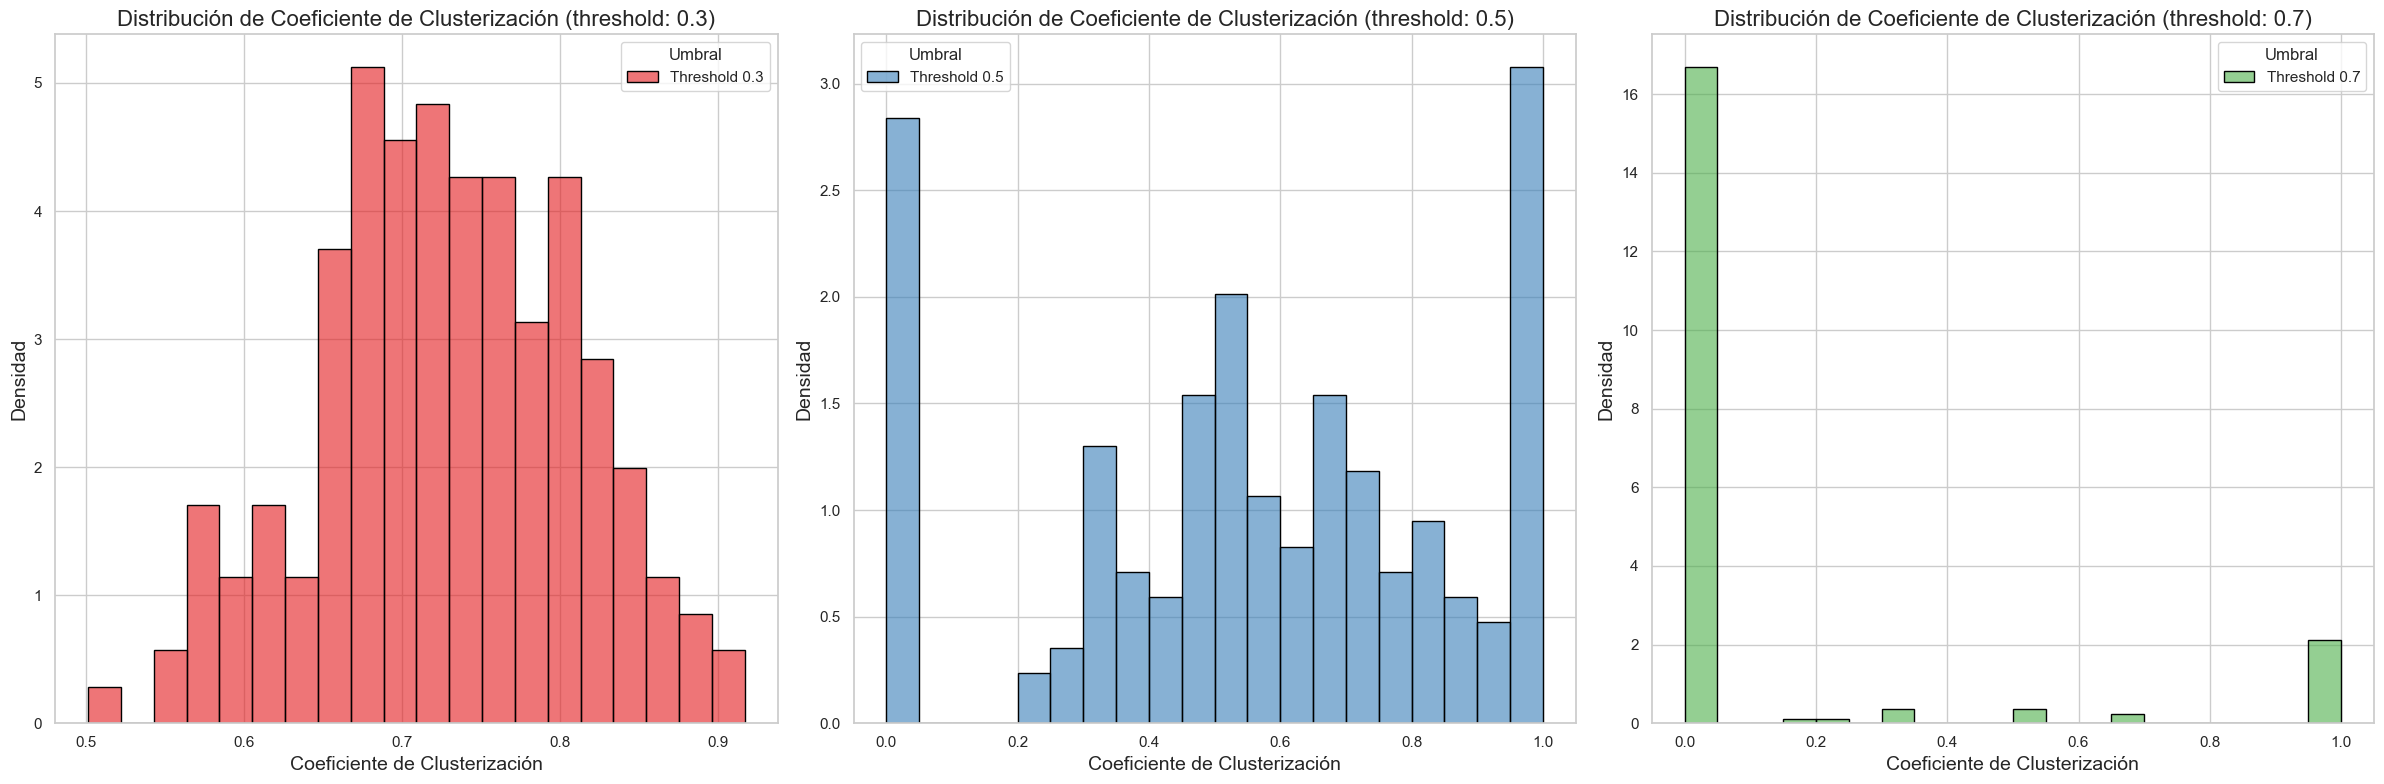

In [5]:
# ==========================================
# Paso 9: Crear y Visualizar la Distribución de Coeficiente de Clusterización en Subgráficos Separados
# ==========================================
# Crear una nueva figura para la distribución de coeficiente de clusterización con 3 subgráficos
fig_cluster, axes_cluster = plt.subplots(1, 3, figsize=(24, 8))

# Iterar sobre cada grafo para calcular y plotear la distribución de coeficientes de clusterización
for idx, (clave, G) in enumerate(grafos.items()):
    # Calcular el coeficiente de clusterización local para cada nodo
    clustering = nx.clustering(G)
    
    # Convertir a una serie de pandas para facilitar el manejo
    clustering_series = pd.Series(clustering)
    
    # Plotear el histograma de coeficientes de clusterización en su propio subgráfico
    sns.histplot(clustering_series, bins=20,  # Puedes ajustar el número de bins según tus necesidades
                 kde=False, stat="density", label=f'Threshold {thresholds[clave]}', 
                 color=palette[idx], alpha=0.6, edgecolor='black', ax=axes_cluster[idx])
    
    # Añadir título y etiquetas a cada subgráfico
    axes_cluster[idx].set_title(f'Distribución de Coeficiente de Clusterización (threshold: {thresholds[clave]})', fontsize=16)
    axes_cluster[idx].set_xlabel('Coeficiente de Clusterización', fontsize=14)
    axes_cluster[idx].set_ylabel('Densidad', fontsize=14)
    
    # Añadir leyenda a cada subgráfico
    axes_cluster[idx].legend(title='Umbral')

# Ajustar el layout y mostrar la figura de la distribución de coeficiente de clusterización
plt.tight_layout()
plt.show()

In [6]:
# ==========================================
# Paso 12: Calcular y Mostrar el Coeficiente de Clusterización Promedio para Cada Grafo
# ==========================================
print("Coeficiente de Clusterización Promedio para Cada Grafo:")
for clave, G in grafos.items():
    promedio_cluster = nx.average_clustering(G)
    print(f"Threshold {thresholds[clave]}: {promedio_cluster:.4f}")

Coeficiente de Clusterización Promedio para Cada Grafo:
Threshold 0.3: 0.7283
Threshold 0.5: 0.5616
Threshold 0.7: 0.1314


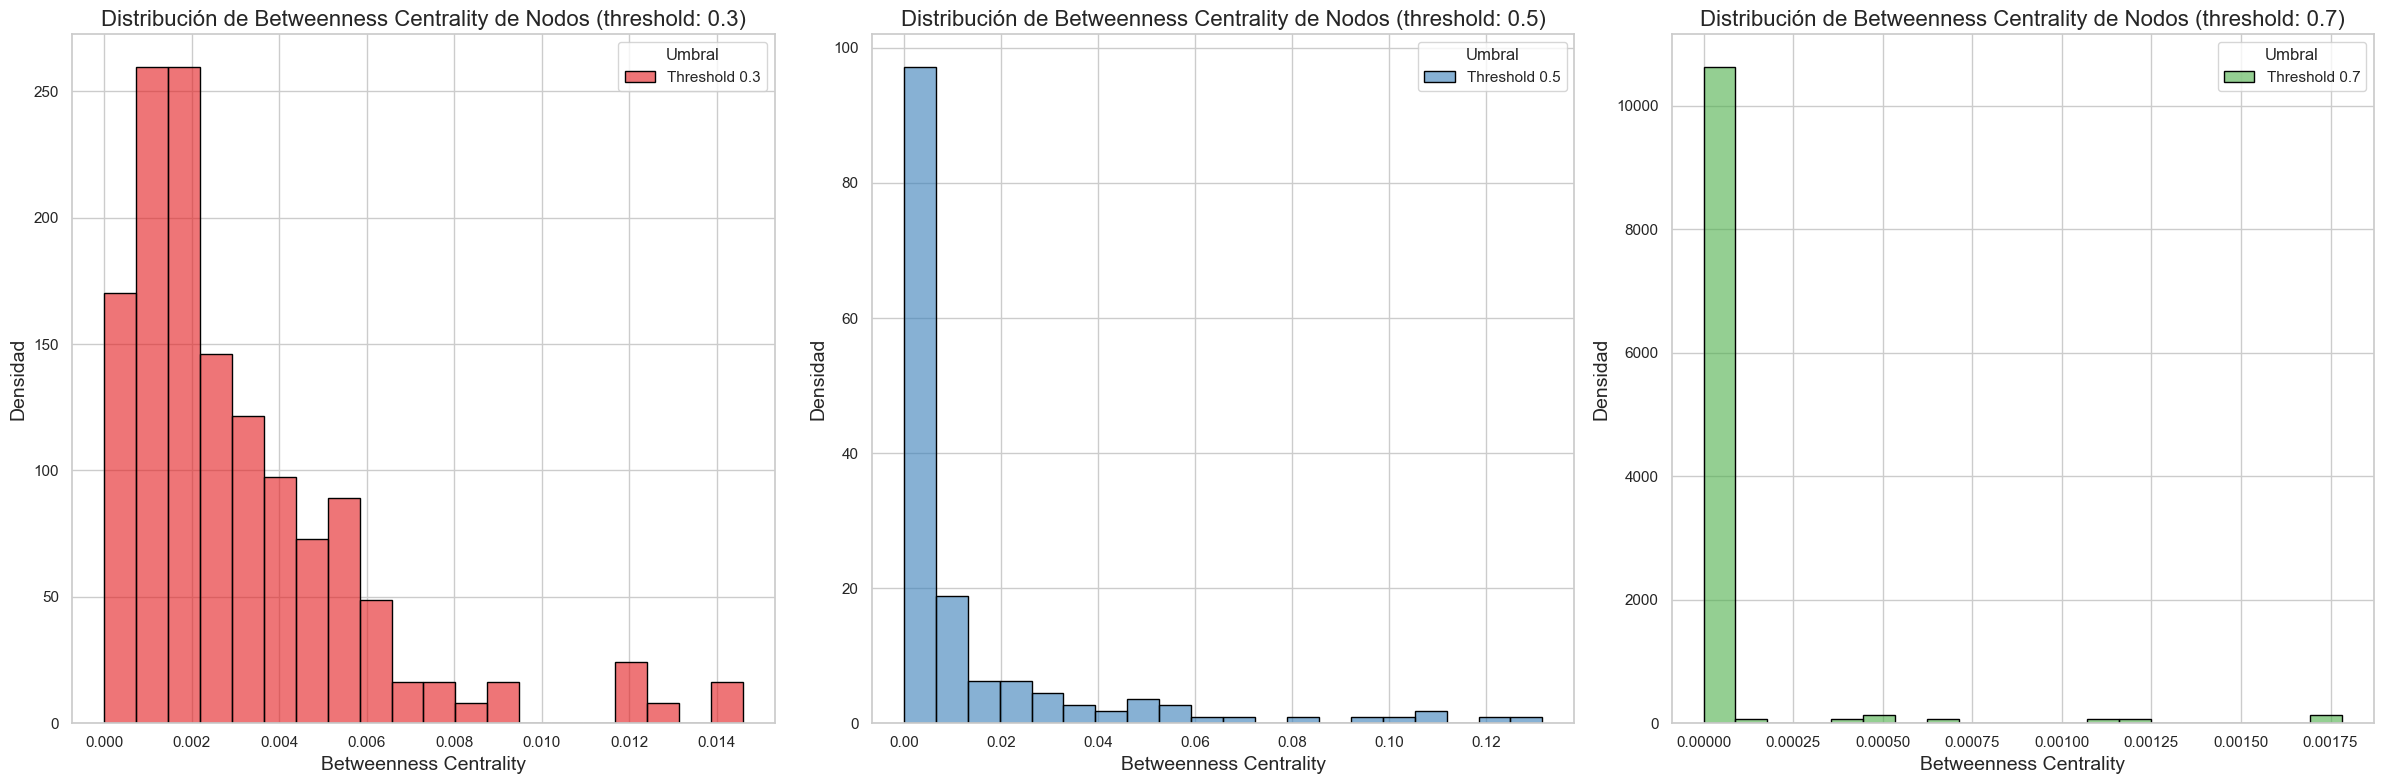

In [7]:
# ==========================================
# Paso 9: Crear y Visualizar la Distribución de Betweenness Centrality de Nodos en Subgráficos Separados
# ==========================================
# Crear una nueva figura para la distribución de betweenness centrality de nodos con 3 subgráficos
fig_betweenness_nodes, axes_betweenness_nodes = plt.subplots(1, 3, figsize=(24, 8))

# Iterar sobre cada grafo para calcular y plotear la distribución de betweenness centrality de nodos
for idx, (clave, G) in enumerate(grafos.items()):
    # Calcular el betweenness centrality para nodos
    betweenness_nodes = nx.betweenness_centrality(G)
    
    # Convertir a una serie de pandas para facilitar el manejo
    betweenness_series = pd.Series(betweenness_nodes)
    
    # Plotear el histograma de betweenness centrality de nodos en su propio subgráfico
    sns.histplot(betweenness_series, bins=20, 
                 kde=False, stat="density", label=f'Threshold {thresholds[clave]}', 
                 color=palette[idx], alpha=0.6, edgecolor='black', ax=axes_betweenness_nodes[idx])
    
    # Añadir título y etiquetas a cada subgráfico
    axes_betweenness_nodes[idx].set_title(f'Distribución de Betweenness Centrality de Nodos (threshold: {thresholds[clave]})', fontsize=16)
    axes_betweenness_nodes[idx].set_xlabel('Betweenness Centrality', fontsize=14)
    axes_betweenness_nodes[idx].set_ylabel('Densidad', fontsize=14)
    
    # Añadir leyenda a cada subgráfico
    axes_betweenness_nodes[idx].legend(title='Umbral')

# Ajustar el layout y mostrar la figura de la distribución de betweenness centrality de nodos
plt.tight_layout()
plt.show()

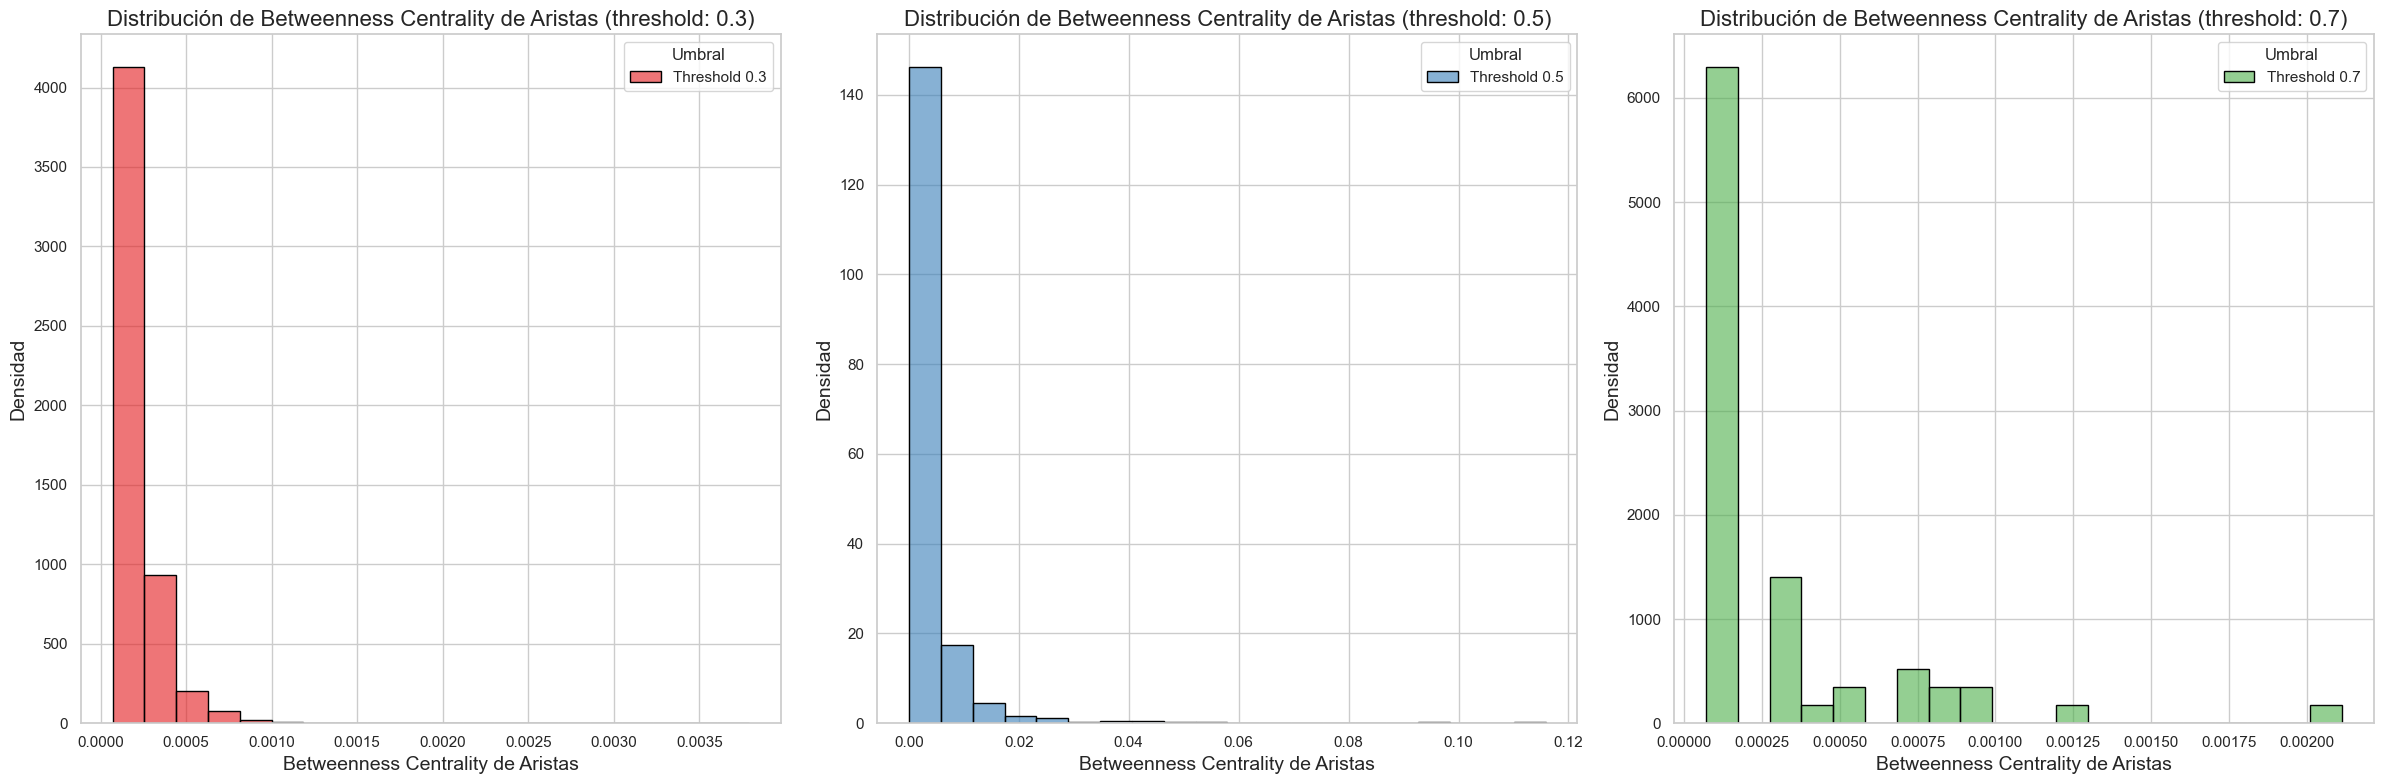

In [8]:
# ==========================================
# Paso 10: Crear y Visualizar la Distribución de Betweenness Centrality de Aristas en Subgráficos Separados
# ==========================================
# Crear una nueva figura para la distribución de betweenness centrality de aristas con 3 subgráficos
fig_betweenness_edges, axes_betweenness_edges = plt.subplots(1, 3, figsize=(24, 8))

# Iterar sobre cada grafo para calcular y plotear la distribución de betweenness centrality de aristas
for idx, (clave, G) in enumerate(grafos.items()):
    # Calcular el betweenness centrality para aristas
    betweenness_edges = nx.edge_betweenness_centrality(G)
    
    # Convertir a una serie de pandas para facilitar el manejo
    betweenness_series_edges = pd.Series(betweenness_edges)
    
    # Plotear el histograma de betweenness centrality de aristas en su propio subgráfico
    sns.histplot(betweenness_series_edges, bins=20, 
                 kde=False, stat="density", label=f'Threshold {thresholds[clave]}', 
                 color=palette[idx], alpha=0.6, edgecolor='black', ax=axes_betweenness_edges[idx])
    
    # Añadir título y etiquetas a cada subgráfico
    axes_betweenness_edges[idx].set_title(f'Distribución de Betweenness Centrality de Aristas (threshold: {thresholds[clave]})', fontsize=16)
    axes_betweenness_edges[idx].set_xlabel('Betweenness Centrality de Aristas', fontsize=14)
    axes_betweenness_edges[idx].set_ylabel('Densidad', fontsize=14)
    
    # Añadir leyenda a cada subgráfico
    axes_betweenness_edges[idx].legend(title='Umbral')

# Ajustar el layout y mostrar la figura de la distribución de betweenness centrality de aristas
plt.tight_layout()
plt.show()


In [9]:
# ==========================================
# Paso 14: Calcular y Mostrar Métricas Resumidas
# ==========================================
print("\n=== Métricas Resumidas para Cada Grafo ===\n")
for clave, G in grafos.items():
    # Coeficiente de Clusterización Promedio
    promedio_cluster = nx.average_clustering(G)
    
    # Betweenness Centrality Promedio para Nodos
    betweenness_nodes = nx.betweenness_centrality(G)
    promedio_betweenness_nodes = sum(betweenness_nodes.values()) / len(betweenness_nodes)
    
    # Betweenness Centrality Promedio para Aristas
    betweenness_edges = nx.edge_betweenness_centrality(G)
    promedio_betweenness_edges = sum(betweenness_edges.values()) / len(betweenness_edges) if betweenness_edges else 0
    
    print(f"Threshold {thresholds[clave]}:")
    print(f"  - Coeficiente de Clusterización Promedio: {promedio_cluster:.4f}")
    print(f"  - Betweenness Centrality Promedio de Nodos: {promedio_betweenness_nodes:.4f}")
    print(f"  - Betweenness Centrality Promedio de Aristas: {promedio_betweenness_edges:.4f}\n")


=== Métricas Resumidas para Cada Grafo ===

Threshold 0.3:
  - Coeficiente de Clusterización Promedio: 0.7283
  - Betweenness Centrality Promedio de Nodos: 0.0031
  - Betweenness Centrality Promedio de Aristas: 0.0002

Threshold 0.5:
  - Coeficiente de Clusterización Promedio: 0.5616
  - Betweenness Centrality Promedio de Nodos: 0.0132
  - Betweenness Centrality Promedio de Aristas: 0.0036

Threshold 0.7:
  - Coeficiente de Clusterización Promedio: 0.1314
  - Betweenness Centrality Promedio de Nodos: 0.0000
  - Betweenness Centrality Promedio de Aristas: 0.0003

